## Compare filters

In [1]:
import sys
sys.path.append('/home/eay8226/gcm-filters')
import numpy as np
import matplotlib.pyplot as plt
from gcm_filters import filter
from gcm_filters.kernels import GridType
from vorticity import compute_vorticity

In [2]:
import os
print(os.getcwd())

/home/arthur/python/NYU/gcm-filters/mom5_example


Script parameters

In [3]:
filter_scale=4
cmap='Spectral'
vmax=0.2
vmin=-vmax

plt_args = dict(vmin=vmin, vmax=vmax, cmap=cmap)

Read the data from North Atlantic


In [4]:
from read_data import read_data
data_location = '/media/arthur/DATA/Data sets/CM2.6'
grid_filename = 'grid_dataforeli'
uv_filename = 'uv_dataforeli'

grid_data, data = read_data(data_location, uv_filename, grid_filename)
grid_data = grid_data.compute().reset_coords()
data_saved = data
grid_data_save = grid_data

data = data['usurf'].isel(time=0).sel(xu_ocean=slice(-50, -30),
                                      yu_ocean=slice(20, 40)).compute()

Question: how do we address continents?

Problem: we need the grid vars to be on the same grid as the field to
be filtered. Here I've interpolated, but I think this is not right,
we can probably just redefine the coords of dxt and dyt to be those of the
velocities, we'll just have to be careful.

In [5]:
# Dont't do interp
grid_data = grid_data[['dxt', 'dyt', 'dxu', 'dyu', 'area_u']]
grid_data['dxt'] = grid_data['dxt'].interp(dict(xt_ocean=data.xu_ocean,
                                  yt_ocean=data.yu_ocean), method='nearest')
grid_data['dyt'] = grid_data['dyt'].interp(dict(xt_ocean=data.xu_ocean,
                                  yt_ocean=data.yu_ocean), method='nearest')
grid_data = grid_data.sel(xu_ocean=slice(-50, -30), yu_ocean=slice(20, 40))
del grid_data['xt_ocean']
del grid_data['yt_ocean']
print(grid_data)

<xarray.Dataset>
Dimensions:   (xu_ocean: 200, yu_ocean: 233)
Coordinates:
  * xu_ocean  (xu_ocean) float64 -49.9 -49.8 -49.7 -49.6 ... -30.2 -30.1 -30.0
  * yu_ocean  (yu_ocean) float64 20.08 20.17 20.26 20.36 ... 39.84 39.91 39.99
    time      object 0181-01-01 12:00:00
Data variables:
    dxt       (yu_ocean, xu_ocean) float64 1.044e+04 1.044e+04 ... 8.524e+03
    dyt       (yu_ocean, xu_ocean) float64 1.044e+04 1.044e+04 ... 8.524e+03
    dxu       (yu_ocean, xu_ocean) float64 1.044e+04 1.044e+04 ... 8.519e+03
    dyu       (yu_ocean, xu_ocean) float64 1.044e+04 1.044e+04 ... 8.519e+03
    area_u    (yu_ocean, xu_ocean) float32 1.091e+08 1.091e+08 ... 7.258e+07
Attributes:
    NCO:      4.0.3


Create the filter and print its specs

In [7]:
dx_min = np.min(grid_data['dxt'].values)
mom5_filterU = filter.Filter(1e5, dx_min=dx_min,
                                 filter_shape=filter.FilterShape.GAUSSIAN,
                                 grid_vars=grid_data,
                                 grid_type=GridType.MOM5U)

grid_dataT = grid_data_save[['dxt', 'dyt', 'dxu', 'dyu', 'area_t']]
grid_dataT['dxu'] = grid_dataT['dxu'].interp(dict(xu_ocean=grid_dataT.xt_ocean,
                                  yu_ocean=grid_dataT.yt_ocean), method='nearest')
grid_dataT['dyu'] = grid_dataT['dyu'].interp(dict(xu_ocean=grid_dataT.xt_ocean,
                                  yu_ocean=grid_dataT.yt_ocean), method='nearest')
grid_dataT = grid_dataT.sel(xt_ocean=slice(-50, -30), yt_ocean=slice(20, 40))
del grid_dataT['xu_ocean']
del grid_dataT['yu_ocean']

mom5_filterT = filter.Filter(1e5, dx_min=dx_min,
                                 filter_shape=filter.FilterShape.GAUSSIAN,
                                 grid_vars=grid_dataT,
                                 grid_type=GridType.MOM5T)

Compute the vorticity field

In [8]:
data = data_saved.sel(xu_ocean=slice(-50, -30), yu_ocean=slice(20, 40))
data = data.isel(time=0)
grid_data = grid_data_save
grid_data = grid_data[['dxt', 'dyt', 'dxu', 'dyu', 'area_u']]
grid_data = grid_data.sel(xu_ocean=slice(-50, -30), yu_ocean=slice(20, 40))
grid_data = grid_data.sel(xt_ocean=slice(-50, -30), yt_ocean=slice(20, 40))

vorticity = compute_vorticity(data, grid_data)

In [9]:
print(vorticity)

<xarray.DataArray (yt_ocean: 233, xt_ocean: 200)>
array([[ 6.91189883e-310,  6.91189883e-310,  0.00000000e+000, ...,
         7.45628533e+060,  7.45628533e+060,  7.45628533e+060],
       [ 7.45628533e+060, -2.33599410e-002, -3.04679023e-002, ...,
         1.37096582e-002,  1.28820847e-002,  7.20348486e+060],
       [ 7.20348486e+060, -2.71608265e-002, -1.84325774e-002, ...,
         1.73997210e-002,  1.73787757e-002,  6.95089282e+060],
       ...,
       [ 8.99430104e+003, -2.00706890e-002, -6.31871857e-003, ...,
        -8.17508718e-002, -8.25783907e-002,  1.05495465e+004],
       [ 1.05553528e+004, -5.59980899e-002, -2.52330131e-002, ...,
        -8.37494645e-002, -9.34794945e-002,  1.11168469e+004],
       [ 1.11164068e+004,  1.11159328e+004,  1.11154250e+004, ...,
         1.04090639e+004,  1.04026624e+004,  1.03962372e+004]])
Coordinates:
  * xt_ocean  (xt_ocean) float64 -49.95 -49.85 -49.75 ... -30.25 -30.15 -30.05
  * yt_ocean  (yt_ocean) float64 20.03 20.12 20.22 20.31 ... 39.8

Carry out filtering operation

In [10]:
filtered_vorticity = mom5_filterT.apply(vorticity, dims=['yt_ocean',
                                                         'xt_ocean'])

Plot the result

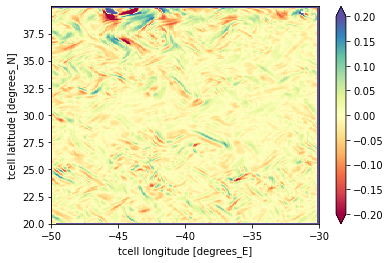

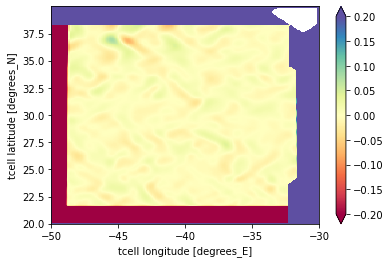

In [11]:
plt.figure()
vorticity.plot(**plt_args)
plt.figure()
filtered_vorticity.plot(**plt_args)
plt.show()

Plot of dxt over the map

In [ ]:
plt.figure()
grid_data['dxu'].plot(cmap='Spectral')#%%


Here we use a cartesian filter

In [ ]:
wet_mask = grid_data_save['wet'].interp(xt_ocean=data.xu_ocean,
                                        yt_ocean=data.yu_ocean)

cartesian_filter = filter.Filter(16, dx_min=1, n_steps=30,
                                 filter_shape=filter.FilterShape.GAUSSIAN,
                                 grid_vars={'wet_mask': wet_mask},
                                 grid_type=GridType.CARTESIAN_WITH_LAND)
filtered_data3 = cartesian_filter.apply(data, dims=['yu_ocean', 'xu_ocean'])

filtered_data3.plot(**plt_args)